# Forecasting problems

Here we can find different approaches to forecast 3 different consumer package goods products, from statistis to deep learning models.

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('src/forecast/')

from utils import *
from deeplearning import DeepLearningModel, scale_data, time_series_to_X_y, plot_predictions
from automl import AutoMLModel, plot_prophet_predictions


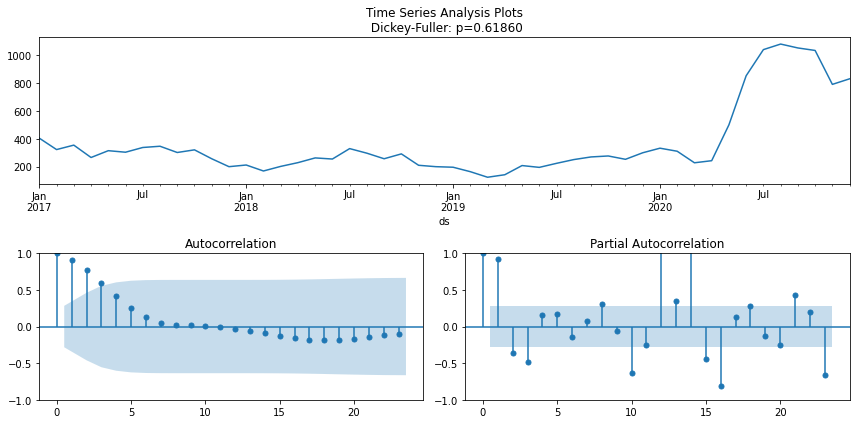

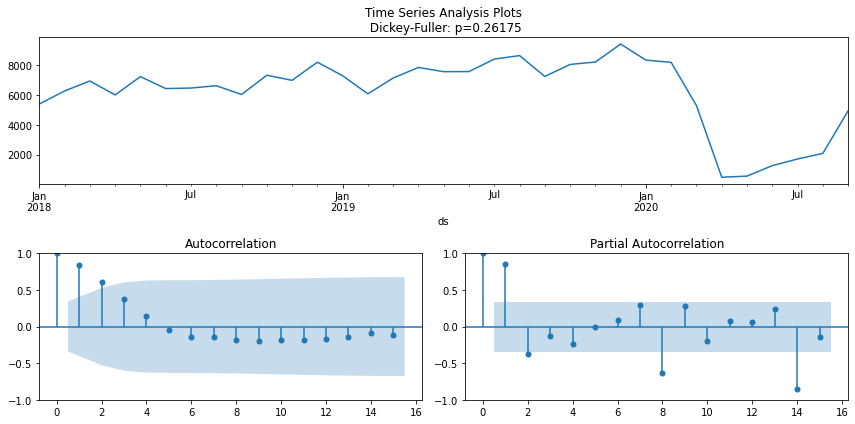

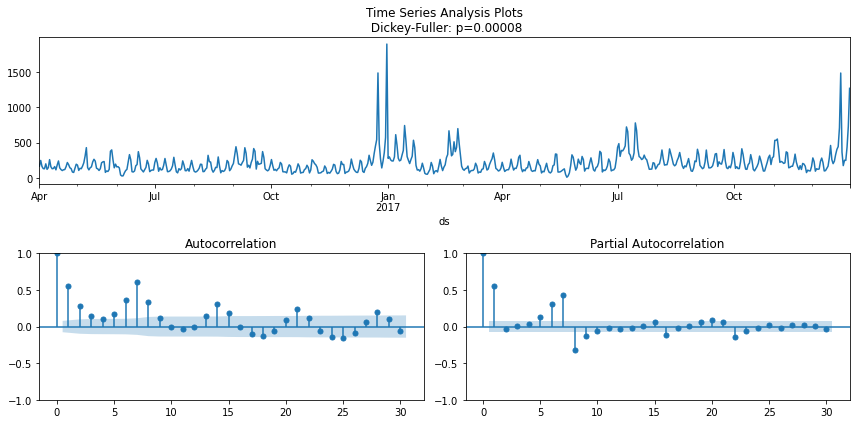

In [2]:
df_paths = ["data/producto_A.csv", "data/producto_B.csv", "data/producto_C.csv"]

for i in df_paths:
    df = get_data(i)
    df.set_index("ds", inplace=True)
    max_lags = min(int(len(df) / 2) - 1, 30)
    tsplot(df.y, lags=max_lags)

## Producto A
Pronóstico de demanda mensual de producto orgánico natural para la salud comercializado a través de canales minoristas en Perú.

In [3]:
df = get_data("data/producto_A.csv")
df.shape

(48, 2)

## Producto C:
Pronóstico de demanda diaria de bebida carbonatada comercializada a través de canales minoristas en Ecuador.

In [4]:
df = get_data("data/producto_C.csv")
df.shape

(640, 2)

### Deep Learning Model (CNN)

In [5]:
train, val, test = time_series_split(df, n_val=60, n_test=30)
data_scaled, scaler = scale_data([train, val, test], scaler_type="standard")
train_set, val_set, test_set = time_series_to_X_y(data_scaled, window_size=7)

In [6]:
m1 = DeepLearningModel("CNN", filters=200, window_size=7)
m1.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 200)            600       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 20)                24020     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________


2022-01-09 16:00:40.214711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
m1.fit(train_set, val_set, epochs=50)

Epoch 1/50
17/17 [==============================] - 0s 8ms/step - loss: 1.0220 - root_mean_squared_error: 1.0109 - val_loss: 0.5162 - val_root_mean_squared_error: 0.7185
Epoch 2/50
17/17 [==============================] - 0s 2ms/step - loss: 0.8657 - root_mean_squared_error: 0.9304 - val_loss: 0.4369 - val_root_mean_squared_error: 0.6610
Epoch 3/50
17/17 [==============================] - 0s 2ms/step - loss: 0.7549 - root_mean_squared_error: 0.8688 - val_loss: 0.3845 - val_root_mean_squared_error: 0.6201
Epoch 4/50
17/17 [==============================] - 0s 2ms/step - loss: 0.6924 - root_mean_squared_error: 0.8321 - val_loss: 0.3480 - val_root_mean_squared_error: 0.5899
Epoch 5/50
17/17 [==============================] - 0s 2ms/step - loss: 0.6401 - root_mean_squared_error: 0.8001 - val_loss: 0.3276 - val_root_mean_squared_error: 0.5724
Epoch 6/50
17/17 [==============================] - 0s 2ms/step - loss: 0.6026 - root_mean_squared_error: 0.7763 - val_loss: 0.3118 - val_root_mean_sq

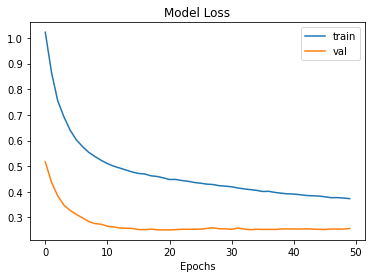

In [8]:
m1.plot_loss_function()

RMSE: 147.91
MAPE: 39.04%
MASE: 137.06%


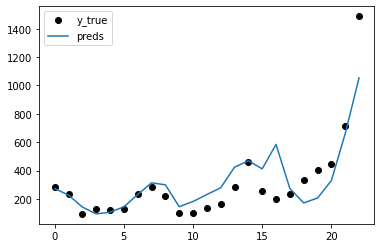

In [9]:
X_test = test_set[0]
y_preds = m1.predict(X_test) # Due to transform for NN model the test set loss the last 7 preds
y_preds = scaler.inverse_transform(y_preds).flatten()

y_train = np.concatenate([train,val]).flatten()
y_test = test.flatten()[:len(y_preds)] # Ensure the test set is the same length as the preds

plot_predictions(y_test, y_preds, y_train)

### Auto ML Model (Prophet)

In [10]:
train_set = df[:-30]
test_set = df[-30:]

In [11]:
holidays = pd.DataFrame(
    {
        "holiday": ["Christmas", "Christmas", "New Year", "New Year"],
        "ds": ["2016-12-24", "2017-12-24", "2016-12-31", "2017-12-31"],
    }
)

In [12]:
m2 = AutoMLModel("Prophet", yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m2.fit(train_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.88756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1679.4    0.00103033        83.945           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1680.86   0.000625385       249.236   5.983e-06       0.001      294  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       1680.95   2.68433e-05       66.2475   3.752e-07       0.001      383  LS failed, Hessian reset 
     260       1680.95    4.1947e-08       62.4923      0.3166      0.3166      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [13]:
m2.plot_components()

In [14]:
forecast = m2.predict(periods=30, freq="D")
m2.plot_model_forecast(forecast)

RMSE: 144.57
MAPE: 33.67%
MASE: 127.15%


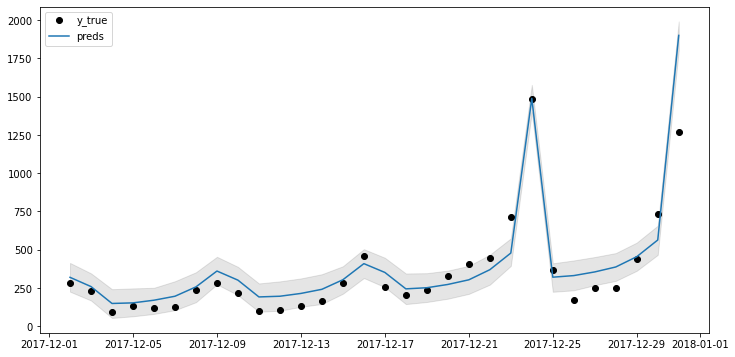

In [15]:
y_test = test_set.y.to_numpy()
y_preds = forecast.tail(len(test_set)).yhat.to_numpy()
y_train = train_set.y.to_numpy()

print_metrics(y_test, y_preds, y_train)
plot_prophet_predictions(test_set, forecast)

In [17]:
# Plot metrics comparable to the DeepLearning Model (23 steps)
print_metrics(y_test[:-7], y_preds[:-7], y_train)

RMSE: 78.98
MAPE: 31.86%
MASE: 89.29%
